# 📊 Análisis Exploratorio de Datos Clínicos (NHANES)

## 🎯 Objetivo
Este notebook realiza un **Análisis Exploratorio de Datos (EDA)** exhaustivo sobre el dataset clínico procesado de NHANES (National Health and Nutrition Examination Survey).

El objetivo principal es validar la calidad de los datos, entender las distribuciones de los nuevos biomarcadores clínicos y evaluar su poder predictivo frente a la variable objetivo: **Enfermedad Cardíaca (HeartDisease)**.

## 🛠️ Herramientas Utilizadas
- **Pandas**: Para manipulación y estructuración de datos.
- **Sweetviz**: Para generación automática de reportes visuales comparativos.
- **Matplotlib/Seaborn**: Para análisis de correlaciones y visualizaciones específicas.

## 📋 Flujo de Trabajo
1. **Carga de Datos**: Importar el dataset `process_data.parquet`.
2. **Análisis Estadístico**: Validar rangos, promedios y desviaciones.
3. **Correlación**: Identificar multicolinealidad entre variables.
4. **Reporte Automático**: Generar HTML con `Sweetviz` para análisis visual profundo.

In [ ]:
# Instalación de dependencias si es necesario
# !pip install sweetviz pandas pyarrow matplotlib seaborn

### 🔹 Paso 1: Importación de Librerías y Configuración Global
En este primer paso, importamos las bibliotecas esenciales para el análisis:
- **Pandas**: Para la manipulación de estructuras de datos tabulares (DataFrames).
- **Sweetviz**: Una potente librería para generar reportes de EDA automatizados y visuales.
- **Matplotlib y Seaborn**: Para la creación de gráficos estáticos y mapas de calor personalizados.
También configuramos la visualización de pandas para mostrar todas las columnas, facilitando la exploración visual.

In [1]:
import pandas as pd
import sweetviz as sv
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de visualización
pd.set_option('display.max_columns', None)


## 1. Carga y Preparación de Datos

En esta sección cargamos los datos procesados. El formato **Parquet** se utiliza por su eficiencia en lectura y escritura, preservando los tipos de datos.

El dataset ya ha sido procesado y las columnas estandarizadas al inglés en la etapa de extracción (`00_Data_Extraction.ipynb`).

### 🔹 Paso 2: Carga del Dataset Procesado
Cargamos el archivo `process_data.parquet` desde la capa intermedia de datos.
Utilizamos el formato **Parquet** por ser más eficiente en almacenamiento y velocidad de lectura que el CSV, además de preservar los tipos de datos (int, float, category) definidos previamente. Verificamos las dimensiones del dataset cargado para confirmar que la ingesta fue correcta.

In [3]:
DATA_PATH = "../data/02_intermediate/process_data.parquet"

try:
    df = pd.read_parquet(DATA_PATH)
    print(f"Datos cargados correctamente. Dimensiones: {df.shape}")
except FileNotFoundError:
    print(f"Error: No se encontró el archivo en {DATA_PATH}")


Datos cargados correctamente. Dimensiones: (43695, 28)


### 🔹 Paso 3: Revisión de Variables
El dataset ya viene limpio y con nombres en inglés. Realizamos una verificación rápida de las columnas disponibles.

In [4]:
# Usar todas las columnas disponibles para el análisis
df_analysis = df.copy()

print(f"Columnas para análisis (Total: {len(df_analysis.columns)}):")
print(df_analysis.columns.tolist())

# Mantenimiento de listas para compatibilidad con celdas posteriores del notebook

# Detectar automáticamente variables numéricas para la matriz de correlación
numeric_cols = df_analysis.select_dtypes(include=['number']).columns.tolist()
if 'HeartDisease' in numeric_cols:
    numeric_cols.remove('HeartDisease')

# 'biomarkers' se usa en la celda siguiente para .describe()
# Ahora incluye todas las variables numéricas (biomarcadores + demografía numérica etc.)
biomarkers = numeric_cols

# 'categorical_vars' para referencia
categorical_vars = df_analysis.select_dtypes(exclude=['number']).columns.tolist()
if 'HeartDisease' not in categorical_vars and 'HeartDisease' in df_analysis.columns:
    categorical_vars.append('HeartDisease')


Columnas para análisis (Total: 28):
['SEQN', 'Sex', 'Age', 'Race', 'Education', 'IncomeRatio', 'HeartDisease', 'Presion_Sistolica', 'BMI', 'WaistCircumference', 'Height', 'TotalCholesterol', 'Triglycerides', 'LDL', 'HbA1c', 'Glucose', 'Creatinine', 'UricAcid', 'ALT_Enzyme', 'Albumin', 'Potassium', 'Sodium', 'GGT_Enzyme', 'AST_Enzyme', 'Smoking', 'Actividad_Fisica', 'HealthInsurance', 'Alcohol']


## 2. Validación Estadística y Detección de Outliers

Antes de modelar, es crítico entender la "forma" de nuestros datos. Utilizamos `.describe()` para obtener un resumen estadístico de las variables numéricas:
- **Count**: ¿Tenemos datos faltantes?
- **Mean/Std**: ¿Cuál es el valor típico y qué tanto varían los datos?
- **Min/Max**: ¿Existen valores fisiológicamente imposibles? (Ej. BMI < 10 o Glucosa = 0).

Este paso nos permite identificar errores de calidad de datos o necesidad de limpieza adicional.

### 🔹 Paso 4: Análisis Estadístico Descriptivo
Ejecutamos `.describe()` para obtener una radiografía estadística de los biomarcadores numéricos.
Buscamos activamente:
- **Medias y Desviaciones**: Para entender la dispersión de datos como el Colesterol o la Glucosa.
- **Mínimos y Máximos**: Cruciales para detectar valores atípicos (outliers) o errores de medición (ej. una altura negativa o una presión arterial imposible).
- **Conteo de Nulos**: Confirmamos que no existan valores faltantes que puedan romper los modelos.

In [5]:
# Estadísticas descriptivas de biomarcadores numéricos
numeric_cols = [c for c in biomarkers if c in df_analysis.columns]
desc = df_analysis[numeric_cols].describe()
print(desc)

# Chequeo rápido de valores nulos
print("\nValores Nulos:")
print(df_analysis.isnull().sum())

                SEQN           Sex           Age          Race     Education  \
count   43695.000000  43695.000000  43695.000000  43695.000000  26280.000000   
mean    91539.061403      1.505641     33.638105      3.167410      3.502207   
std     20081.363565      0.499974     24.477865      1.262611      1.256845   
min     62161.000000      1.000000      1.000000      1.000000      1.000000   
25%     75195.500000      1.000000     11.000000      2.000000      3.000000   
50%     86569.000000      2.000000     30.000000      3.000000      4.000000   
75%    113488.500000      2.000000     55.000000      4.000000      4.000000   
max    124822.000000      2.000000     80.000000      5.000000      9.000000   

        IncomeRatio  Presion_Sistolica           BMI  WaistCircumference  \
count  3.898000e+04       32295.000000  39550.000000        37752.000000   
mean   2.309488e+00         119.346111     26.004561           88.006574   
std    1.625913e+00          18.678179      8.08011

## 2.1 Verificación de Consistencia Clínica (Friedewald)

**Diagnóstico**: Verificamos que los datos respeten la fisiología humana básica.
Aplicamos la **Fórmula de Friedewald** ($LDL_{calc} = ColesterolTotal - HDL - (Triglicéridos/5)$) para validar la coherencia entre los lípidos reportados.
Si los puntos se alinean en la diagonal, los datos son consistentes. Desviaciones indican problemas de calidad o imputación.

In [ ]:
# Verificación de Consistencia Clínica
def friedewald_validation(df):
    # Mapeo de columnas flexibles (Inglés/Español)
    col_map = {
        'TC': ['TotalCholesterol', 'Colesterol_Total', 'LBXTC'],
        'HDL': ['HDL', 'Colesterol_HDL', 'LBDHDD'],
        'Trig': ['Triglycerides', 'Trigliceridos', 'LBXTR'],
        'LDL': ['LDL', 'Colesterol_LDL', 'LBDLDL']
    }
    
    cols = {}
    for k, aliases in col_map.items():
        for a in aliases:
            if a in df.columns:
                cols[k] = a
                break
    
    # Verificación de existencia de columnas
    missing = set(col_map.keys()) - set(cols.keys())
    
    # Si falta HDL (común en algunos datasets procesados), intentamos inferirlo o advertimos
    if 'HDL' not in cols:
        if 'TC' in cols and 'LDL' in cols and 'Trig' in cols:
             print("ℹ️ Columna HDL explícita no encontrada. Derivando HDL implícito para visualización (Sanity Check)...")
             df['HDL_Implied'] = df[cols['TC']] - df[cols['LDL']] - (df[cols['Trig']] / 5)
             cols['HDL'] = 'HDL_Implied'
        else:
             print(f"⚠️ Faltan columnas críticas para validación Friedewald: {missing}. Se omite el gráfico.")
             return

    # Calcular LDL Teórico
    # LDL_calc = TC - HDL - (Trig / 5)
    ldl_calc = df[cols['TC']] - df[cols['HDL']] - (df[cols['Trig']] / 5)
    
    # Visualización
    plt.figure(figsize=(8, 6))
    plt.scatter(df[cols['LDL']], ldl_calc, alpha=0.3, c='blue', label='Pacientes', edgecolors='w', linewidth=0.5)
    
    # Línea de identidad
    min_val = min(df[cols['LDL']].min(), ldl_calc.min())
    max_val = max(df[cols['LDL']].max(), ldl_calc.max())
    plt.plot([min_val, max_val], [min_val, max_val], 'r--', label='Identidad Perfecta (Teórico = Reportado)')
    
    plt.xlabel(f"LDL Reportado ({cols['LDL']})")
    plt.ylabel("LDL Calculado (Friedewald)")
    plt.title("Validación Fisiológica: Consistencia de Lípidos")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()
    
    # Métricas de consistencia
    corr = df[cols['LDL']].corr(ldl_calc)
    print(f"Correlación Pearson (Reportado vs Calculado): {corr:.4f}")
    
    # Advertencia automática
    if corr < 0.9:
        print("⚠️ ADVERTENCIA CRÍTICA: Baja consistencia biológica (< 0.9). Revisar proceso de imputación o calidad de datos.")
    else:
        print("✅ Consistencia Biológica Aceptable.")

try:
    friedewald_validation(df_analysis)
except Exception as e:
    print(f"No se pudo ejecutar la validación clínica: {e}")


## 3. Análisis de Correlación (Pearson)

Buscamos **multicolinealidad** (variables que explican lo mismo) y relaciones fuertes con el target.
- Usamos el coeficiente de correlación de **Pearson**.
- Un valor cercano a **1** indica correlación positiva fuerte.
- Un valor cercano a **-1** indica correlación negativa fuerte.
- Un valor cercano a **0** indica ausencia de relación lineal.

**Nota**: Variables muy correlacionadas (ej. `SystolicBP` y `DiastolicBP`) podrían introducir redundancia en ciertos modelos lineales, aunque algoritmos de árboles como XGBoost suelen manejarlas bien.

### 🔹 Paso 5: Matriz de Correlación de Pearson
Calculamos y visualizamos la matriz de correlación para identificar:
1.  **Multicolinealidad**: Variables altamente correlacionadas entre sí (ej. Sistólica y Diastólica) que podrían ser redundantes.
2.  **Correlación con el Target**: Identificar qué variables tienen una relación lineal directa con `HeartDisease`.
Usamos un mapa de calor (`heatmap`) donde los colores intensos indican correlaciones fuertes (positivas o negativas).

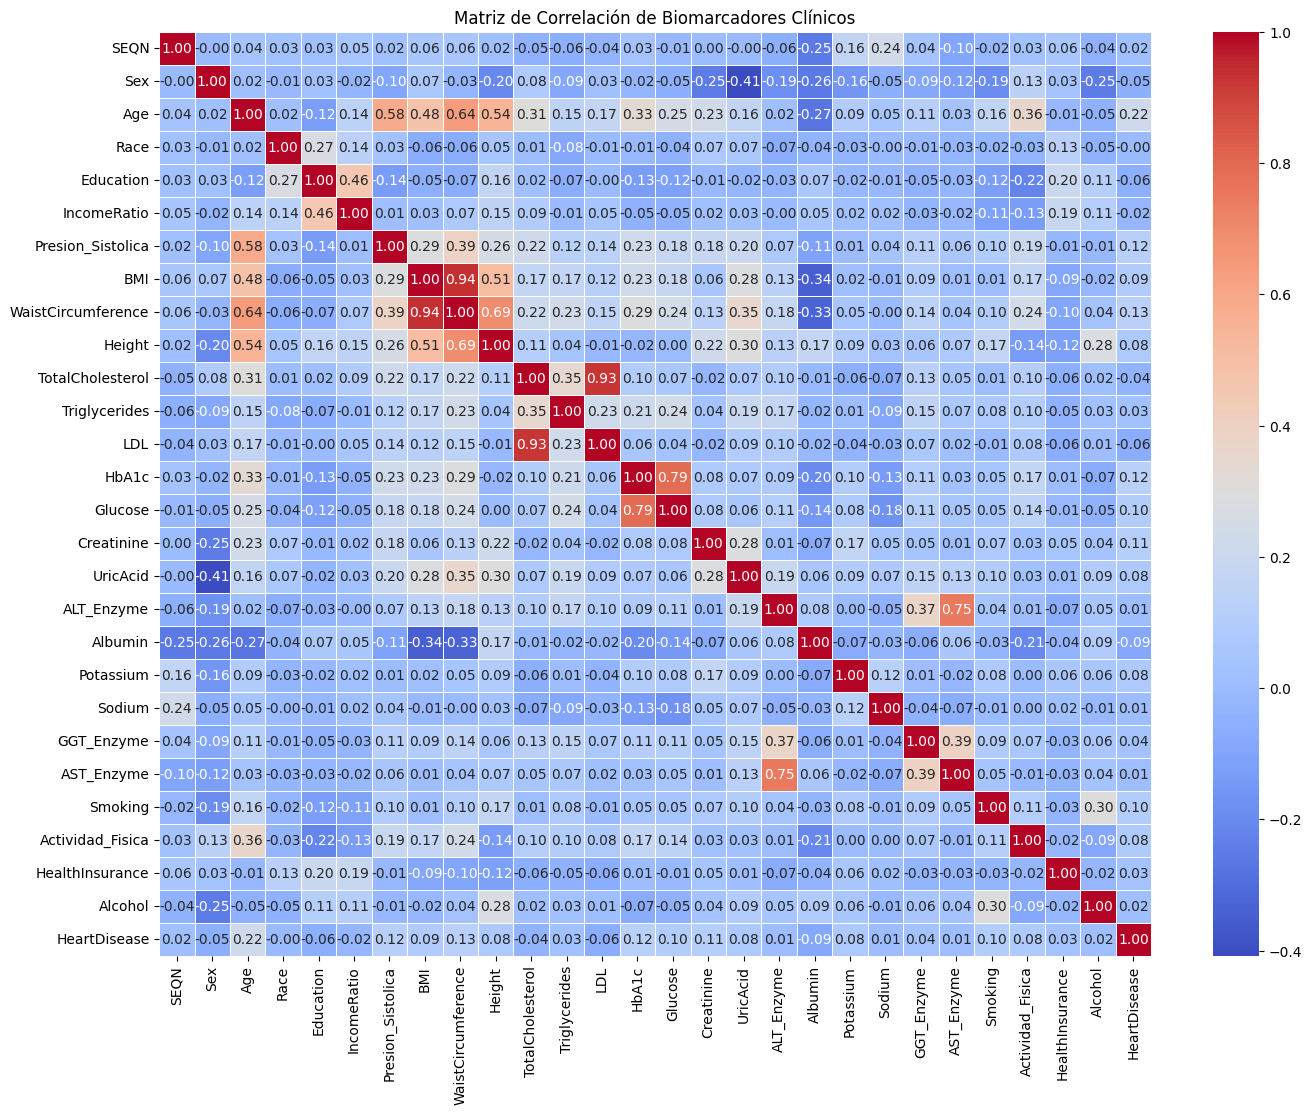

In [6]:
# Matriz de correlación
plt.figure(figsize=(16, 12))
correlation_matrix = df_analysis[numeric_cols + ['HeartDisease']].corr()

sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap='coolwarm', linewidths=0.5)
plt.title("Matriz de Correlación de Biomarcadores Clínicos")
plt.show()

## 4. Reporte Automático con Sweetviz

Para finalizar el EDA, generamos un reporte HTML interactivo completo.
**Sweetviz** compara automáticamente las características de las poblaciones (Sanos vs Enfermos si se configura, o globalmente) y genera histogramas, estadísticas y asociaciones para cada variable.

Este reporte se guardará como `NHANES_Clinical_Analysis.html` y es una herramienta invaluable para compartir hallazgos con el equipo médico/negocio.

In [7]:
# Generar reporte automático
print("Generando reporte Sweetviz...")
report = sv.analyze(df_analysis, target_feat='HeartDisease')
report.show_html('NHANES_Clinical_Analysis.html')
print("Reporte generado: NHANES_Clinical_Analysis.html")

Generando reporte Sweetviz...


                                             |          | [  0%]   00:00 -> (? left)

Report NHANES_Clinical_Analysis.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.
Reporte generado: NHANES_Clinical_Analysis.html
